# Carnatic Music Processing

## Outline / Steps

* Import data
  * Carnatic Varnam dataset audio recordings
* Preprocessing - visualize audio
  * Function 1: Get spectrogram
  * Function 2: Get fundamental pitch contour
  * Function 3: Separation of drone / vocal?
  * Function 4: Annotate percussive onsets
* Feature Calculations
  * Function 5: Plot pitch contour derivative + mark saddle points
  * Function 6: Overall Pitch Statistics (histogram + probability density function)
* Sandbox

* Framework
- parameter + results ()
  - median in addition to mean
- Github
  - clear all outputs
  - setup to commit


## Test File

### Setup

In [1]:
# IMPORTS

import os
import librosa as lb
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import medfilt
from scipy.interpolate import interp1d
import scipy.stats as stats


In [2]:
# LOAD FILE

abhogi1 = 'carnatic_varnam_1.0/Audio/223578__gopalkoduri__carnatic-varnam-by-dharini-in-abhogi-raaga.mp3'  # Replace with your file path
x, sr = lb.load(abhogi1)

### Spectrogram + Pitch Contour Generation

ISSUE: f0 and spectrogram overlay takes forever if mismatch in timesteps, gave them both the same hop_length parameter but play around with this

In [3]:
spec = lb.amplitude_to_db(np.abs(lb.stft(x, n_fft=2048, hop_length=512)), ref=np.max)
f0 = lb.yin(x, fmin=lb.note_to_hz('C2'), fmax=lb.note_to_hz('C7'), hop_length=512)

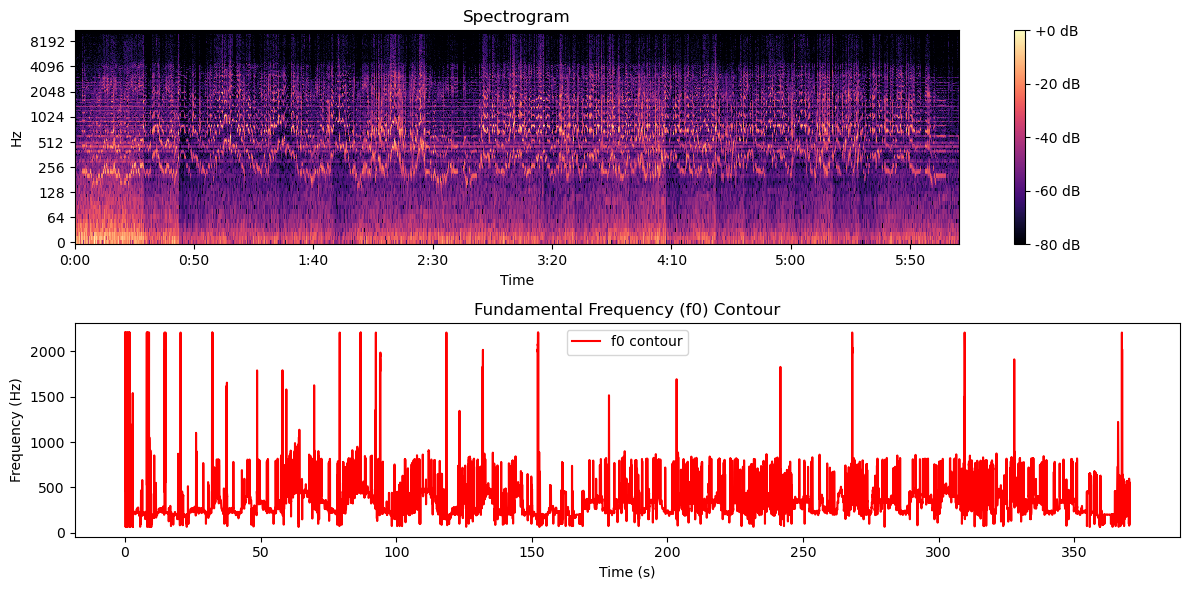

In [4]:
# Plot spectrogram
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
lb.display.specshow(spec, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')

# Plot f0 contour
plt.subplot(2, 1, 2)
times = lb.times_like(f0, sr=sr)
plt.plot(times, f0, label='f0 contour', color='r')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Fundamental Frequency (f0) Contour')
plt.legend()

plt.tight_layout()
plt.show()

ISSUE: slow in general, will start with just ~20 seconds (1000 samples w curr params) of each sample as the default


In [5]:
spec_clip = spec[:, :1000]
f0_clip = f0[:1000]

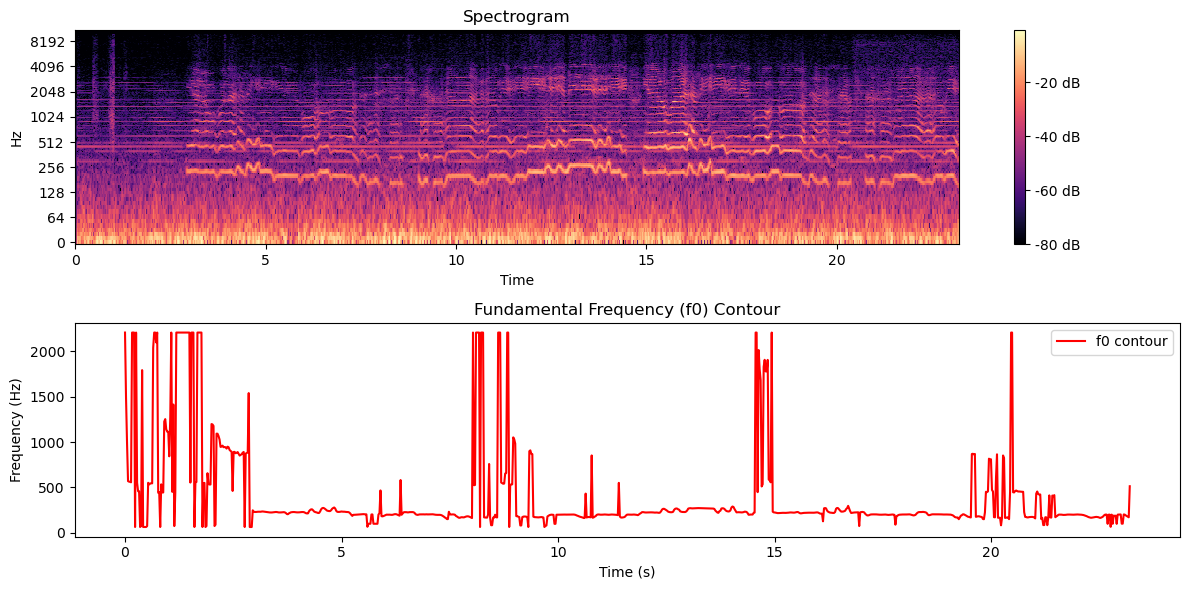

In [6]:
# Plot spectrogram
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
lb.display.specshow(spec_clip, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')

# Plot f0 contour
plt.subplot(2, 1, 2)
times = lb.times_like(f0_clip, sr=sr)
plt.plot(times, f0_clip, label='f0 contour', color='r')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Fundamental Frequency (f0) Contour')
plt.legend()

plt.tight_layout()
plt.show()

/Users/sruthip/miniconda3/envs/fmp/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


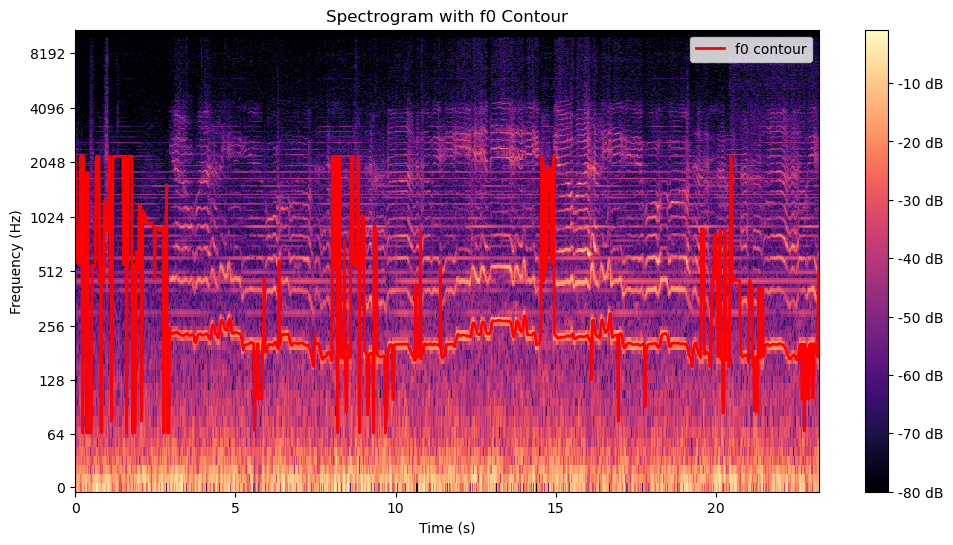

In [7]:
times = lb.times_like(f0_clip, sr=sr, hop_length=512)

# Plot spectrogram
plt.figure(figsize=(12, 6))
lb.display.specshow(spec_clip, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')

# Overlay f0 contour
plt.plot(times, f0_clip, label='f0 contour', color='r', linewidth=2)

# Labels and title
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram with f0 Contour')
plt.legend()

plt.show()

ISSUE: lots of noise (see overlay) -- how to remove?

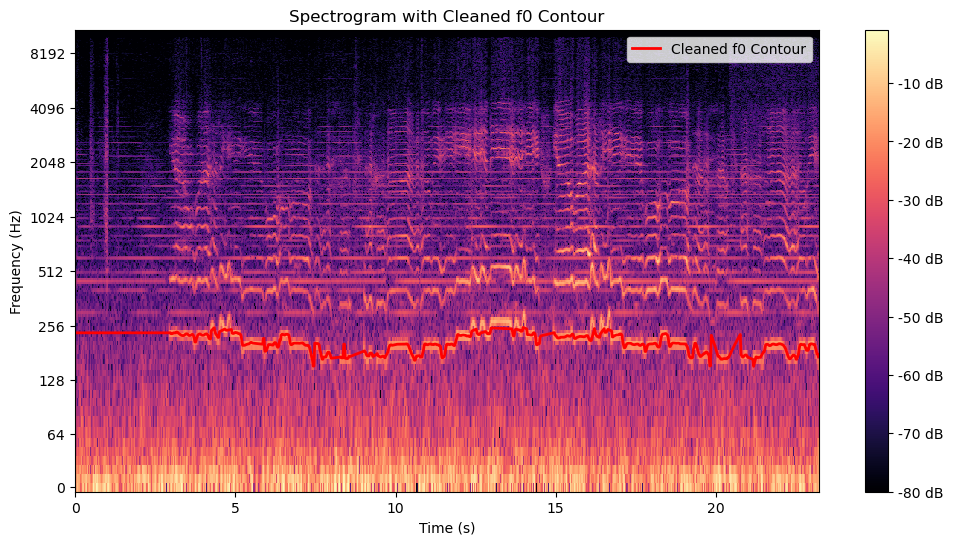

In [8]:
# Apply median filtering to remove noise
f0_filtered = medfilt(f0_clip, kernel_size=3)

# Remove out-of-bounds values
fmin_hz = 110 # ranges from cepstrum paper
fmax_hz = 250
f0_filtered = np.where((f0_filtered > fmin_hz) & (f0_filtered < fmax_hz), f0_filtered, np.nan)

# Interpolate to fill missing values
times = lb.times_like(f0_clip, sr=sr, hop_length=512)
valid = ~np.isnan(f0_filtered)
interp_func = interp1d(times[valid], f0_filtered[valid], kind='linear', fill_value="extrapolate")
f0_smooth = interp_func(times)

# Plot spectrogram
plt.figure(figsize=(12, 6))
lb.display.specshow(spec_clip, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')

# Overlay f0 contour
plt.plot(times, f0_smooth, label='Cleaned f0 Contour', color='r', linewidth=2)

# Labels and title
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram with Cleaned f0 Contour')
plt.legend()

plt.show()

### Pitch Contour Features

1. Pitch Contour Derivative
2. "Saddle" Points / Local Optima (Derivative = 0)
* derivative contour has many spikes / jumps  -- tried smoothing with a convolution (similar to median filtering and smoothing of f0)
* zero crossings are still not marked at the exact locations because they are often between samples -- tried linear interpolation for markers and timestamps
3. Onsets (for Note Boundaries)


/var/folders/v0/bh252q5575v1xj0_rkb78szm0000gp/T/ipykernel_50572/733498880.py:46: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


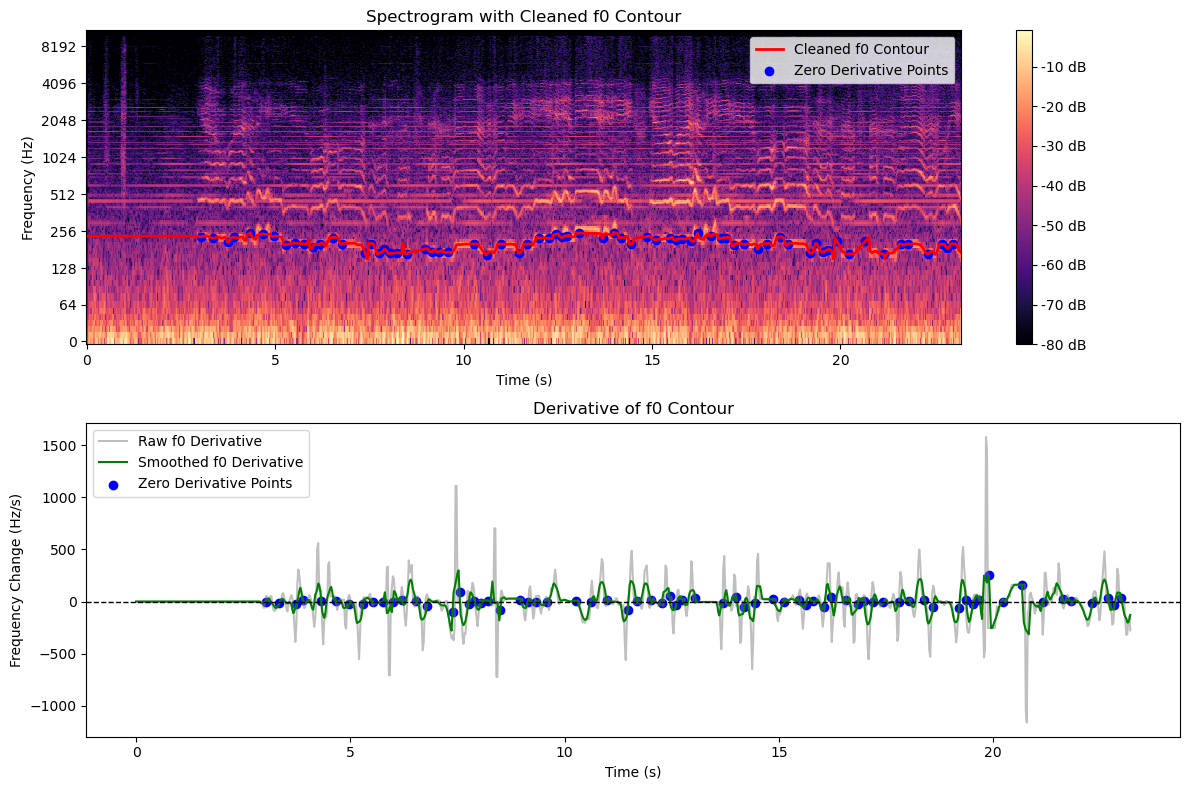

In [9]:
def smooth_signal(signal, kernel_size=5):
    """Apply a moving average filter to smooth the signal."""
    kernel = np.ones(kernel_size) / kernel_size
    return np.convolve(signal, kernel, mode='same')

# Compute derivative of f0
f0_derivative = np.gradient(f0_smooth, times)# Smooth the derivative to remove noise
f0_derivative_smooth = smooth_signal(f0_derivative, kernel_size=7)


# Find sign changes
sign_changes = np.diff(np.sign(f0_derivative_smooth))

# Find indices where sign change is significant
zero_crossings = np.where(np.abs(sign_changes) == 2)[0]  # Only strong sign flips

# OPTIONAL: Further filter to ignore rapid oscillations (set minimum spacing)
min_spacing = 5  # Adjust as needed based on hop_length and sampling rate
zero_crossings = zero_crossings[np.diff(np.concatenate(([0], zero_crossings))) > min_spacing]

# Plot spectrogram
plt.figure(figsize=(12, 8))

# Plot spectrogram with f0 contour
plt.subplot(2, 1, 1)
lb.display.specshow(spec_clip, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.plot(times, f0_smooth, label='Cleaned f0 Contour', color='r', linewidth=2)
plt.scatter(times[zero_crossings], f0_smooth[zero_crossings], color='b', marker='o', label='Zero Derivative Points')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram with Cleaned f0 Contour')
plt.legend()

# Plot derivative of f0
plt.subplot(2, 1, 2)
plt.plot(times, f0_derivative, color='gray', alpha=0.5, label='Raw f0 Derivative')
plt.plot(times, f0_derivative_smooth, color='g', label='Smoothed f0 Derivative')
plt.axhline(0, color='k', linestyle='--', linewidth=1)  # Reference line at 0
plt.scatter(times[zero_crossings], f0_derivative_smooth[zero_crossings], color='b', marker='o', label='Zero Derivative Points')
plt.xlabel('Time (s)')
plt.ylabel('Frequency Change (Hz/s)')
plt.title('Derivative of f0 Contour')
plt.legend()

plt.tight_layout()
plt.show()


4. Pitch Histogram
* in terms of midi and not frequency to be scaled for perceived pitch (can also display on a log scale)
5. Pitch PDF
* uses kernel density estimation (built-in) with a Gaussian kernel

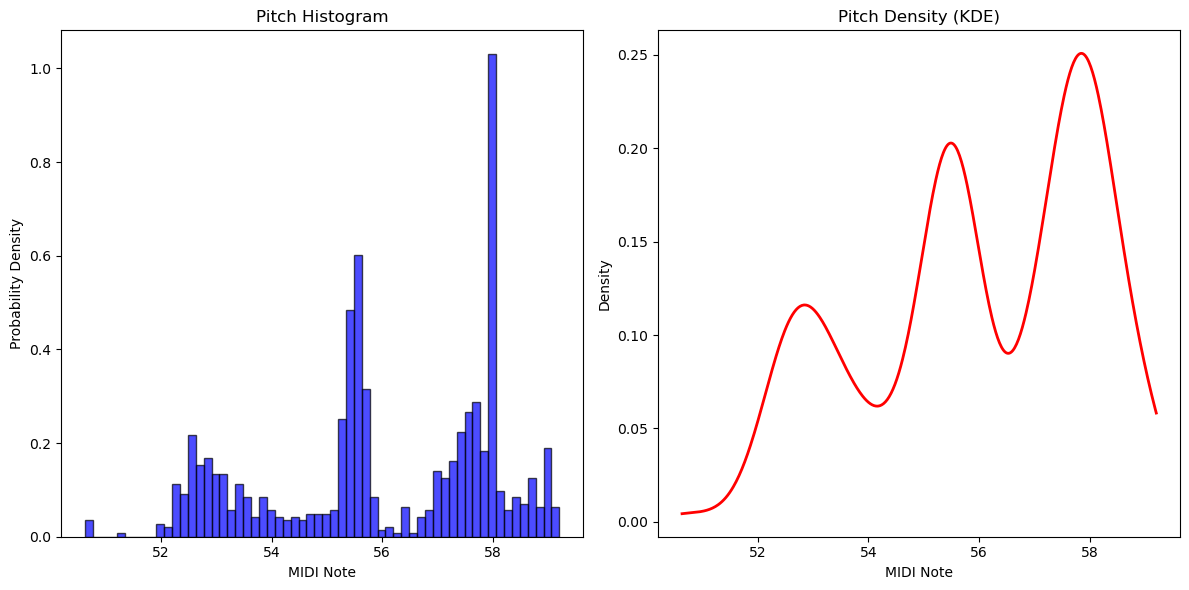

In [10]:
f0_clean = np.interp(times, times[valid], f0_filtered[valid])

# Convert f0 to MIDI note numbers
pitch_midi = lb.hz_to_midi(f0_clean)

# Plot pitch histogram
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(pitch_midi, bins=60, density=True, alpha=0.7, color='b', edgecolor='black')
plt.xlabel('MIDI Note')
plt.ylabel('Probability Density')
plt.title('Pitch Histogram')

# Compute Kernel Density Estimation (KDE)
kde = stats.gaussian_kde(pitch_midi)
pitch_range = np.linspace(min(pitch_midi), max(pitch_midi), 500)
kde_values = kde(pitch_range)

# Plot KDE-based PDF
plt.subplot(1, 2, 2)
plt.plot(pitch_range, kde_values, color='r', linewidth=2)
plt.xlabel('MIDI Note')
plt.ylabel('Density')
plt.title('Pitch Density (KDE)')

plt.tight_layout()
plt.show()
